In [2]:
# Importação da biblioteca Pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Importações das biliotecas Sklearn, Skforecast e ARIMA
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from pmdarima.arima import auto_arima

In [6]:
# Carrega os dados com Pandas: a base escolhida é um CSV que traz a oscilação dos preços de alimentos na India do ano 2000 até 2020 (mensal).
data = pd.read_csv("datasets/timeSeries.csv")
rows, cols = data.shape
print(f'O DataFrame possui {rows} linhas e {cols} colunas.')
data.head(5)

O DataFrame possui 240 linhas e 8 colunas.


,date,Chickpeas,Oil (mustard),Potatoes,Rice,Sugar,Wheat,Onions
0,2000-02,18.896667,45.690000,4.933333,236.494444,16.270588,205.003846,5.246667
1,2000-03,18.160000,43.621875,4.365000,223.215789,16.613889,245.025000,5.680000
2,2000-04,18.500000,42.965625,4.742500,231.990556,17.041667,234.041429,5.487500
3,2000-05,18.295000,41.340625,4.855000,231.355556,16.641667,219.606667,5.257500
4,2000-06,18.840000,42.080000,5.090000,230.888889,16.635294,217.806667,4.827500


In [31]:
# Seleciona apenas as colunas que serão utilizadas, sendo a de datas e a que traz os preços de batatas.
data = data[['date', 'Potatoes']]
data.head(5)

,date,Potatoes
0,2000-02,4.933333
1,2000-03,4.365000
2,2000-04,4.742500
3,2000-05,4.855000
4,2000-06,5.090000


In [32]:
# Exibe o tipo do dado das colunas selecionadas
data.dtypes

date         object
Potatoes    float64
dtype: object

In [33]:
# Converte data de object para datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m') # format='%m-%d-%Y

In [34]:
# Exibe o tipo do dado das colunas selecionadas, agora pós conversão da coluna de datas
data.dtypes

date        datetime64[ns]
Potatoes           float64
dtype: object

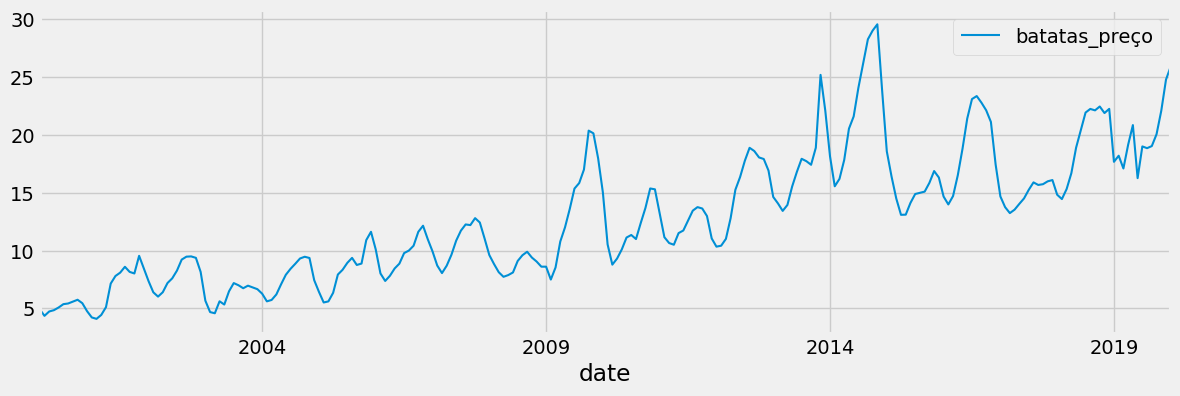

In [35]:
# Renomeia a coluna com os preços de batata
data = data.rename(columns={'Potatoes': 'batatas_preço'})

# Seta o índice como a coluna e datas
data = data.set_index('date')

# Define a frequência (mensal)
data = data.asfreq('MS', fill_value=0.0)

# Ordena pela data
data = data.sort_index()

# Plota o gráfico da osiclação de preço de batatas
fig, ax = plt.subplots(figsize=(13, 4))
data['batatas_preço'].plot(ax=ax, label='batatas_preço')
ax.legend();

In [36]:
# Exibe se há linhas com valores nulos 
print(f'Número de linhas com valores nulos: {data.isnull().any(axis=1).mean()}')

Número de linhas com valores nulos: 0.0


In [7]:
# Código para verificar se não existem "buracos" nos dados, ou seja, verifica se meu índice setado está completo e sem datas faltantes
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Intervalo de datas para treinamento: 2000-02-01 00:00:00 --- 2017-06-01 00:00:00  (n=209)
Intervalo de datas para teste:       2017-07-01 00:00:00 --- 2020-01-01 00:00:00  (n=31)


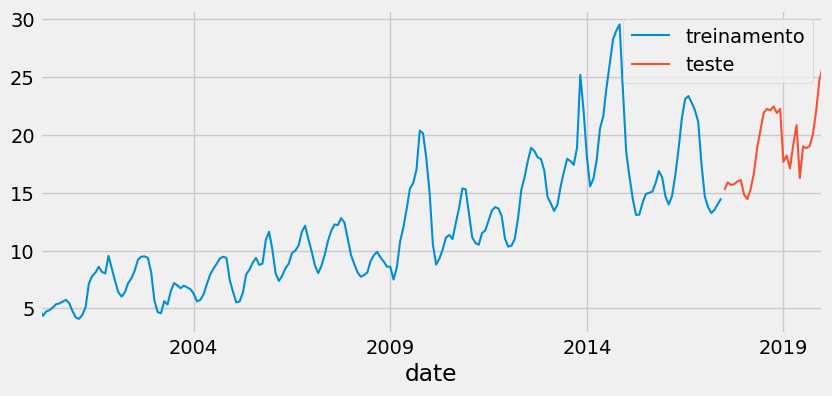

In [99]:
# Divide a base de dados em treinamento e teste, utilizando os 31 últimos registros como teste
steps = 31
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Intervalo de datas para treinamento: {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Intervalo de datas para teste:       {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['batatas_preço'].plot(ax=ax, label='treinamento')
data_test['batatas_preço'].plot(ax=ax, label='teste')
ax.legend();

In [95]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros definidos através de teste manual
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=365, random_state=123),
                lags      = 12
             )

forecaster.fit(y=data_train['batatas_preço'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=365, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-02-01 00:00:00'), Timestamp('2017-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 365, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-06-04 19:34:02 
La

In [96]:
# Faz predição no conjunto de teste
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-07-01    14.577207
2017-08-01    14.602721
2017-09-01    14.588230
2017-10-01    14.531880
2017-11-01    14.474035
Freq: MS, Name: pred, dtype: float64

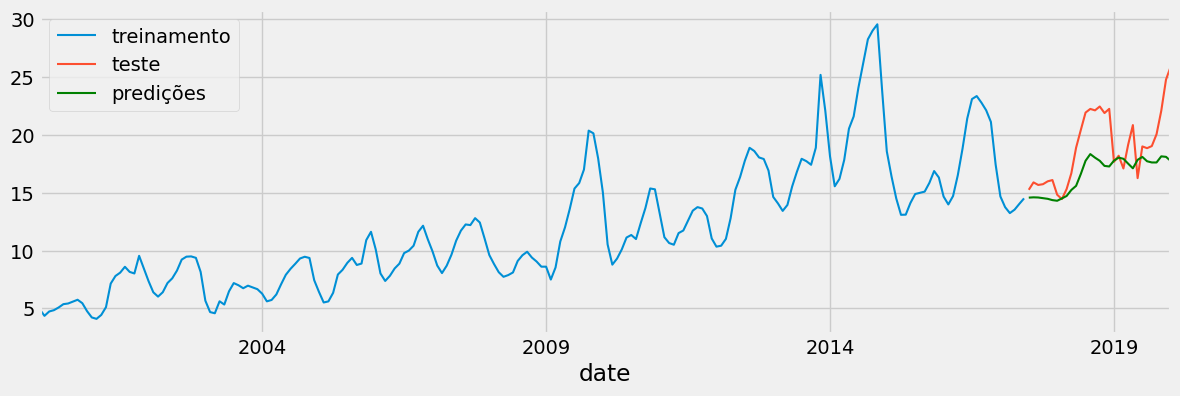

In [97]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(13, 4))
data_train['batatas_preço'].plot(ax=ax, label='treinamento')
data_test['batatas_preço'].plot(ax=ax, label='teste')
predictions.plot(ax=ax, label='predições', color='green')
ax.legend();

In [70]:
# O ARIMA vem com um tunning automático, o auto_arima
model = auto_arima(data_train['batatas_preço'], trace=True, error_action='ignore', suppress_warnings=True)
# Treina o modelo
model.fit(data_train['batatas_preço'])
# Faz a previsão
forecast = model.predict(n_periods=len(data_test))
# Converte para um dataframe
forecast = pd.DataFrame(forecast,index = data_test.index,columns=['Predição'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=734.300, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=661.215, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=662.308, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=732.525, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=650.021, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=650.686, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=653.389, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=648.118, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=659.278, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=648.800, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=630.900, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=651.466, Time=0.0

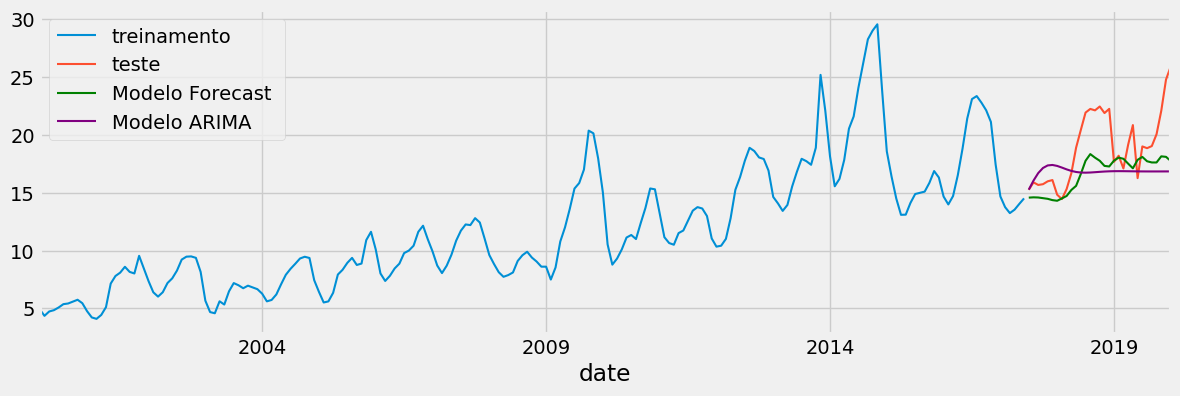

In [72]:
# Plota a predição, comparando com valores reais e modelos Forecast e ARIMA
fig, ax=plt.subplots(figsize=(13, 4))
data_train['batatas_preço'].plot(ax=ax, label='treinamento')
data_test['batatas_preço'].plot(ax=ax, label='teste')
predictions.plot(ax=ax, label='Modelo Forecast ', color='green')
forecast['Predição'].plot(ax=ax, label='Modelo ARIMA', color='purple')
ax.legend();